# Tutorial: context aware learning of multiple modalities with mmcontext

## Contents of Tutorial

This tutorial demonstrates how to use the mmcontext package to preprocess single-cell data. We'll walk through the steps of:

**Preprocessing**:
1. Loading the Dataset
2. Generating Embeddings
3. Normalizing Embeddings
4. Aligning Embeddings
5. Constructing the Dataset
6. Creating a Data Loader

**Model fitting**:
1. Initialize the model
2. Configure the loss
3. Train the model

### Preprocessing
#### 1. Loading the Dataset

The input data has to be an {class}`anndata.AnnData` object. First, we'll load the example dataset provided in data/small_cellxgene.h5ad. It is derived from the cellxgene census {cite:p}`czi2023cz` and contains cells of various tissues and celltypes from different studys. The scvi embedding included is provided by cellxgene and contains embeddings computed with the scvi variational autoencoder trained on the cellxgene corpus. It is a custom made dataset that contains data from various tissues originating from different datasets.

In [ ]:
# Import necessary libraries
import anndata


data_path = "../../data/test_data/test_cellxgene.h5ad"
# Load the dataset
adata = anndata.read_h5ad(data_path)
# Display basic information about the dataset
adata

AnnData object with n_obs × n_vars = 280000 × 5000
    obs: 'soma_joinid', 'donor_id', 'disease', 'sex', 'dataset_id', 'cell_type', 'assay', 'tissue', 'cell_type_ontology_term_id', 'assay_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_length', 'nnz', 'n_measured_obs'
    obsm: 'scvi'

In [4]:
from mmcontext.pp.utils import split_anndata, remove_entries, consolidate_low_frequency_categories

# split anndata into train and test
train_adata, test_adata = split_anndata(adata, train_size=0.8)
remove_entries(train_adata)
remove_entries(test_adata)
# remove cells with less than 10 appearances
train_adata = consolidate_low_frequency_categories(
    train_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)
# remove cells with less than 10 appearances
test_adata = consolidate_low_frequency_categories(
    test_adata, columns=["cell_type", "dataset_id"], threshold=5, remove=True
)

mmcontext - INFO - Logging configured using the specified configuration file.
mmcontext.pp.utils - INFO - Removed 34 genes with zero variance.
mmcontext.pp.utils - INFO - No cells with zero variance found.
mmcontext.pp.utils - INFO - Number of zero rows: 0
mmcontext.pp.utils - INFO - Number of zero columns: 34
mmcontext.pp.utils - INFO - Removing zero rows and columns...
mmcontext.pp.utils - INFO - Number of duplicate cells: 0
mmcontext.pp.utils - INFO - No duplicate cells to remove.
mmcontext.pp.utils - INFO - Removed 49 genes with zero variance.
mmcontext.pp.utils - INFO - No cells with zero variance found.
mmcontext.pp.utils - INFO - Number of zero rows: 0
mmcontext.pp.utils - INFO - Number of zero columns: 49
mmcontext.pp.utils - INFO - Removing zero rows and columns...
mmcontext.pp.utils - INFO - Number of duplicate cells: 0
mmcontext.pp.utils - INFO - No duplicate cells to remove.


#### 2. Generate Embeddings

We will generate context embeddings based on the categorical metadata fields cell_type and tissue using the {class}`mmcontext.pp.CategoryEmbedder` class.
The method is based on creating an embedding of the individual categories of a cell with a text model. The `embeddings_file_path` points to a dictionary that contains embeddings for a range of cell types and tissues from the cellxgene corpus, thereby allowing the method to work without needing an API call. Only if some categories are not found in the dictionary the api will be used. If only a few are unknown, these will just be filled with a zero embedding. The `unkown_threshold` parameter controls how many new categories are needed to use the API. For that of course an API Key will be needed, which has to be set as an environmental variable "OPENAI_API_KEY". 

We will use the precomputed data embeddings stored in `adata.obsm['scvi']` as our data embeddings

In [5]:
# Import the CategoryEmbedder class
from mmcontext.pp import CategoryEmbedder, Embedder

# Specify the categories to embed
categories = ["cell_type"]
one_hot = False
# Initialize the CategoryEmbedder
category_embedder = CategoryEmbedder(
    metadata_categories=categories,
    model="text-embedding-3-small",
    combination_method="concatenate",
    embeddings_file_path="../../data/emb_dicts/category_embeddings_text-embedding-3-small_metadata_embeddings.pkl.gz",
    one_hot=one_hot,
)
# Initialize the Embedder without embedders
embedder = Embedder(context_embedder=category_embedder, data_embedder=None)

# Create embeddings using external embeddings
for adata in [train_adata, test_adata]:
    embedder.create_embeddings(adata, data_embeddings=adata.obsm["scvi"])
    # Confirm the shape of the context embeddings
    print("Context Embeddings Shape:", adata.obsm["c_emb"].shape)
    print("Data Embeddings Shape:", adata.obsm["d_emb"].shape)

mmcontext.pp.context_embedder - INFO - Loaded embeddings from file.
mmcontext.pp.context_embedder - INFO - Embeddings dictionary contains the following categories: dict_keys(['cell_type', 'tissue', 'assay']) with a total of 947 elements.
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings Shape: (4283, 1536)
Data Embeddings Shape: (4283, 50)
mmcontext.pp.embedder - INFO - Using external data embeddings provided.
mmcontext.pp.embedder - INFO - Creating context embeddings...
mmcontext.pp.context_embedder - INFO - Embeddings for 'cell_type' stored in adata.obsm['cell_type_emb']
mmcontext.pp.context_embedder - INFO - Combined context embeddings stored in adata.obsm['c_emb']
Context Embeddings 

#### 3. Normalize Embeddings 

Now that the embeddings are created and stored in the adata object we can apply normalization. We will use the {class}`mmcontext.pp.MinMaxNormalizer` here. 

In [6]:
# Import the MinMaxNormalizer class
from mmcontext.pp import MinMaxNormalizer

# Initialize the MinMaxNormalizer
normalizer = MinMaxNormalizer()
# Normalize the embeddings
for adata in [train_adata, test_adata]:
    normalizer.normalize(adata)

    # Confirm that normalized embeddings are stored
    print("Normalized Data Embeddings Shape:", adata.obsm["d_emb_norm"].shape)
    print("Normalized Context Embeddings Shape:", adata.obsm["c_emb_norm"].shape)

mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (4283, 50)
Normalized Context Embeddings Shape: (4283, 1536)
mmcontext.pp.embedding_normalizer - INFO - Normalizing embeddings using min-max normalization...
Normalized Data Embeddings Shape: (928, 50)
Normalized Context Embeddings Shape: (928, 1536)


#### 4. Aligning Embeddings

After normalization we will now use a {class}`mmcontext.pp.DimAligner` to make sure the dimensions of both data and context embeddings are equal, as this will be nescessary for the model. We will use the {class}`mmcontext.pp.PCAReducer` for this. If embeddings are larger than target latent dimension, they will be reduced via PCA. If there are smaller, padding with zeros will be applied. If using the {class}`mmcontext.pp.PCAReducer`, you can evaluate the principal components with some plots and metrics.

In [7]:
from omegaconf import DictConfig

# Create a DictConfig object for the configuration
config = DictConfig(
    {
        "evaluate_pca": True,
        "save_path": "pca_eval_oh",
        "scree_plot": True,
        "cumulative_variance_plot": True,
        "loadings_heatmap": True,
        "loadings_heatmap_options": {
            "threshold": 0,  # Only include loadings above this threshold
            "top_n_components": 64,  # Number of principal components to include in the heatmap
            "top_n_variables": 1000,  # Number of variables to display in the heatmap
        },
    }
)
# Configuration dictionary for PCA evaluation

if config.evaluate_pca and one_hot:
    config.one_hot_order = adata.uns["one_hot_order"]

In [9]:
# Import the PCAReducer class
from mmcontext.pp import PCAReducer

# Initialize the PCAReducer with the desired latent dimension
latent_dim = 64
aligner = PCAReducer(latent_dim=latent_dim, config=config)

# Align the embeddings
for adata in [train_adata, test_adata]:
    aligner.align(adata)

    # Confirm that aligned embeddings are stored
    print("Aligned Data Embeddings Shape:", adata.obsm["d_emb_aligned"].shape)
    print("Aligned Context Embeddings Shape:", adata.obsm["c_emb_aligned"].shape)

mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (4283, 64)
Aligned Context Embeddings Shape: (4283, 64)
mmcontext.pp.dim_aligner - INFO - one_hot_order not provided. Using default feature indices.
mmcontext.pp.dim_aligner - INFO - Applied threshold: 0
mmcontext.pp.dim_aligner - INFO - Selected top 1000 variables based on importance.
mmcontext.pp.dim_aligner - INFO - Loadings heatmap saved to pca_eval_oh\loadings_heatmap.png
mmcontext.pp.dim_aligner - INFO - Loadings heatmap generation complete.
Aligned Data Embeddings Shape: (928, 64)
Aligned Context Embeddings Shape: (928, 64)


#### 5. Constructing the Dataset

Finally, we will construct a dataset using the aligned embeddings, suitable for training models with PyTorch.

In [49]:
# Import the DataSetConstructor class
from mmcontext.pp import DataSetConstructor

# Initialize the DataSetConstructor
train_dataset_constructor = DataSetConstructor(in_sample_id_key="soma_joinid")
test_dataset_constructor = DataSetConstructor(in_sample_id_key="soma_joinid")

# Add the AnnData object to the dataset
train_dataset_constructor.add_anndata(train_adata)
test_dataset_constructor.add_anndata(test_adata)

# The sequence length for the dataset. Since attention mechanisms will be used, samples can be grouped into sequences to perform attention within the sequence.
seq_length = 12
# Construct the dataset
train_dataset = train_dataset_constructor.construct_dataset(seq_length=seq_length)
test_dataset = test_dataset_constructor.construct_dataset(seq_length=seq_length)

#### 6. Create a Dataloader
Create a pyTorch Dataloader which can be iterated over

In [50]:
from torch.utils.data import DataLoader

# Create DataLoader
batch_size = 32  # Number of sequences per batch
if batch_size * seq_length > adata.n_obs:
    raise ValueError("Batch size and sequence length are too large for the dataset.")
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# For now use the test data as validation data
val_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader and verify batch shapes
for batch in train_loader:
    data_embeddings = batch["data_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    context_embeddings = batch["context_embedding"]  # Shape: (batch_size, seq_length, embedding_dim)
    sample_ids = batch["sample_id"]  # Shape: (batch_size, seq_length)

    print(data_embeddings.shape)
    print(context_embeddings.shape)
    print(sample_ids.shape)
    break  # Only need to check the first batch

torch.Size([32, 12, 64])
torch.Size([32, 12, 64])
torch.Size([32, 12])


### Model fitting
#### 1. Initializing the Model
The {class} `mmcontext.engine.MMContextEncoder` is the main encoder which will be used to create embeddings based on the available data and context embeddings. It's structure is flexible and is build upon torchs {class} `torch.nn.TransformerEncoder` which creates stacks of the {class} `mmcontext.engine.CustomTransformerEncoderLayer` which can be configured to be 

1. An MLP only model
2. To apply self attention (use_self_attention = True)
3. To apply cross attention (use_cross_attention = True)
4. To use both self and cross attention (both True)

The model takes two matrix inputs, `in_main` and `in_cross`. in_main will be passed through the MLP and optionally the self-attention layers, while in_cross is only used if cross-attention is used. In the end the model outputs embeddings of the same shape as in_main, updated based on the learning objective. The inputs are handled in the {class} `mmcontext.engine.Trainer` in dependancy with the settings used for the loss. 

In [51]:
from mmcontext.engine import MMContextEncoder

hidden_dim = 64
num_layers = 2
num_heads = 1
model = MMContextEncoder(
    embedding_dim=latent_dim,  # this has to be the same dimension as the latent dimension of the aligner
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    num_heads=num_heads,
    use_self_attention=False,
    use_cross_attention=False,
    activation="relu",
    dropout=0.1,
)

mmcontext.engine.models - INFO - MMContextEncoder initialized with embedding_dim = 64, num_layers = 2, use_self_attention = False, use_cross_attention = False.


#### 2. Configure the loss
The loss function is a central part of this project. The loss is implemented to be extendable and customizable by having a {class} `mmcontext.engine.LossManager` which you can use to add different losses to and which will be passed to the {class} `mmcontext.engine.Trainer` to compute the total loss (as a weighted average of the components) during Training. The current main implementation of a {class} `mmcontext.engine.LossFunction` is the {class} `mmcontext.engine.ContrastiveLoss`, which is a custom approach to contrastive learning. It's main configuration parameters are `target_mode` and `current_mode` which refer to the way in which the target similarity matrix and the current (during model training) similarity matrix are constructed. For example if `target_mode = 'context_context'`, the original context embeddings are used to create the target similarity matrix. Therefore during training, the loss is calcualted as the mean squared error between the current similarity matrix and the one based on the context. If `current_mode = 'data_data'`, the model would learn to find representations of the data that represent similarity found in the respective context.  

In [52]:
from mmcontext.engine import LossManager, ContrastiveLoss

loss_manager = LossManager()
loss_manager.add_loss(ContrastiveLoss(target_mode="infoNCE", current_mode="data_context", similarity_metric="cosine"))

mmcontext.engine.losses - INFO - Adding loss function: ContrastiveLoss(target_mode=infoNCE, current_mode=data_context, similarity_metric=cosine) with weight 1.00


#### 3. Train the Model
The Trainer uses the defined model and loss the conduct training, aiming to iterativly minimize the loss. The {func} `mmcontext.engine.Trainer.fit` method can take a training and a validation dataloader as input. If a validation loader is given and a save_path is used, the weights of the best performing model can be saved to file. The {class} `mmcontext.engine.MMContextEncoder` has a method `load` to load weights from file.
Per default data embeddings are used for in_main while context embeddings are used as in_cross.

In [12]:
from mmcontext.engine import Trainer
import torch

trainer = Trainer(
    model=model,
    loss_manager=loss_manager,
    optimizer=torch.optim.Adam(model.parameters()),
    input_embeddings={"main": "data_embedding", "cross": "context_embedding"},
    temperature=0.07,
)
trainer.fit(train_loader, val_loader, epochs=500, save_path="model.pth")

mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 1/500
mmcontext.engine.trainer - INFO - Batch 10/11, Loss: 6.3437
mmcontext.engine.trainer - INFO - Batch 11/11, Loss: 5.6816
mmcontext.engine.trainer - INFO - Training Epoch Complete. Average Loss: 6.4914
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 5.3388
mmcontext.engine.trainer - INFO - Epoch 1/500 - Train Loss: 6.4914, Val Loss: 5.3388
mmcontext.engine.trainer - INFO - Attempting to save model...
mmcontext.engine.trainer - INFO - Validation loss improved. Model saved to model.pth
mmcontext.engine.trainer - INFO - Temperature: 0.07
mmcontext.engine.trainer - INFO - Starting Epoch 2/500
mmcontext.engine.trainer - INFO - Batch 10/11, Loss: 6.1422
mmcontext.engine.trainer - INFO - Batch 11/11, Loss: 5.5010
mmcontext.engine.trainer - INFO - Training Epoch Complete. Average Loss: 6.1357
mmcontext.engine.trainer - INFO - Validation Complete. Average Loss: 5.2087
mm

In [53]:
import numpy as np

# add a little bit of noise to the test data because otherwise hvg selection evaluation has a problem with the same values
test_adata2 = test_adata.copy()
test_adata2.X += np.random.normal(0, 1e-10, size=test_adata2.X.shape)
# The fitted model can be used to create universial embeddings
model.load(file_path="model.pth")
trainer = Trainer(model=model, input_embeddings={"main": "data_embedding", "cross": "context_embedding"})
inferred_adata = trainer.infer_adata(
    test_adata, sample_id_key="soma_joinid", seq_length=seq_length, batch_size=batch_size
)

mmcontext.engine.models - INFO - Loading model state dictionary from model.pth
mmcontext.engine.trainer - WARNING - Sample ID 58489856 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 42634958 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 28751828 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 28770285 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 42635968 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 58492880 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 11751698 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 58566447 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 16100936 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Sample ID 58494551 not found in inference outputs.
mmcontext.engine.trainer - WARNING - Remo

c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\anndata\_core\storage.py:85: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


#### 4. Evaluate the embeddings
In order to assess the quality of the embeddings, the {class}`mmcontext.eval.Evaluator` can be used. It computes metrics from the scib package {cite:p}`luecken2022benchmarking` in order to asess bioconservation and batch integration. This can also be judged visualy with a umap.

In [54]:
inferred_adata.layers["reconstructed"] = inferred_adata.X + np.random.normal(0, 1e-5, size=inferred_adata.X.shape)

c:\Users\mengerj\AppData\Local\hatch\env\virtual\mmcontext\V2Uk35fS\mmcontext\lib\site-packages\anndata\_core\storage.py:85: ImplicitModificationWarning: Layer 'reconstructed' should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


In [55]:
from mmcontext.pl.plotting import plot_umap
from mmcontext.eval import Evaluator

# Initialize Evaluator
evaluator = Evaluator(
    adata=inferred_adata, batch_key="dataset_id", label_key="cell_type", embedding_key=["scvi", "mod_emb"]
)

res = evaluator.evaluate()

mmcontext.eval.evaluate - INFO - Computing metrics on raw data...
mmcontext.eval.evaluate - INFO - Computing PCA on all genes...
resolution: 0.1, nmi: 0.28264508200653765
resolution: 0.2, nmi: 0.3503533829340155
resolution: 0.3, nmi: 0.37227179346240236
resolution: 0.4, nmi: 0.40940254875476056
resolution: 0.5, nmi: 0.44420870712907395
resolution: 0.6, nmi: 0.4303811210948665
resolution: 0.7, nmi: 0.47121147734692936
resolution: 0.8, nmi: 0.479813447120747
resolution: 0.9, nmi: 0.4824694199319031
resolution: 1.0, nmi: 0.48893280508026105
resolution: 1.1, nmi: 0.49841651238690343
resolution: 1.2, nmi: 0.4986772579093068
resolution: 1.3, nmi: 0.49689796278810366
resolution: 1.4, nmi: 0.49836425950606855
resolution: 1.5, nmi: 0.49791399769004824
resolution: 1.6, nmi: 0.5014167107801488
resolution: 1.7, nmi: 0.4972186722593437
resolution: 1.8, nmi: 0.5018790573433345
resolution: 1.9, nmi: 0.5070936342356722
resolution: 2.0, nmi: 0.5029465275254147
optimised clustering against cell_type
opt

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_3y0w7k4w'>
  _warnings.warn(warn_message, ResourceWarning)


mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.714231
CD1c-positive myeloid dendritic cell          0.218976
CD4-positive, alpha-beta T cell               0.352523
CD8-positive, alpha-beta T cell               0.668085
alveolar macrophage                           0.629054
astrocyte                                     0.633803
capillary endothelial cell                    0.881580
classical monocyte                            0.624461
endothelial cell                              0.852864
fibroblast                                    0.606967
hematopoietic stem cell                       0.268359
macrophage                                    0.666057
malignant cell                                0.228900
microglial cell                               0.677345
monocyte                                      0.424833
myeloid cell                          

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_p9v4ij1l'>
  _warnings.warn(warn_message, ResourceWarning)


resolution: 0.2, nmi: 0.3494634126362115
resolution: 0.3, nmi: 0.3755767572360139
resolution: 0.4, nmi: 0.40940254875476056
resolution: 0.5, nmi: 0.43379011708757165
resolution: 0.6, nmi: 0.43452206526364134
resolution: 0.7, nmi: 0.47121147734692936
resolution: 0.8, nmi: 0.47414303063605057
resolution: 0.9, nmi: 0.48598839457793636
resolution: 1.0, nmi: 0.48937458117042604
resolution: 1.1, nmi: 0.49841651238690343
resolution: 1.2, nmi: 0.49647749627595034
resolution: 1.3, nmi: 0.49689796278810366
resolution: 1.4, nmi: 0.49836425950606855
resolution: 1.5, nmi: 0.49791399769004824
resolution: 1.6, nmi: 0.5014167107801488
resolution: 1.7, nmi: 0.49657589845991923
resolution: 1.8, nmi: 0.5018790573433345
resolution: 1.9, nmi: 0.5031055187398884
resolution: 2.0, nmi: 0.5027276396347774
optimised clustering against cell_type
optimal cluster resolution: 1.9
optimal score: 0.5031055187398884
isolated labels: no more than 1 batches per label
GABAergic amacrine cell: 0.3015523850917816
Mueller c

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_x1vw5jsa'>
  _warnings.warn(warn_message, ResourceWarning)


mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.714234
CD1c-positive myeloid dendritic cell          0.218976
CD4-positive, alpha-beta T cell               0.352523
CD8-positive, alpha-beta T cell               0.668086
alveolar macrophage                           0.629054
astrocyte                                     0.633808
capillary endothelial cell                    0.881584
classical monocyte                            0.624461
endothelial cell                              0.852867
fibroblast                                    0.606966
hematopoietic stem cell                       0.268359
macrophage                                    0.666057
malignant cell                                0.228900
microglial cell                               0.677346
monocyte                                      0.424833
myeloid cell                          

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_n7pf3tiv'>
  _warnings.warn(warn_message, ResourceWarning)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
mmcontext.eval.evaluate - INFO - Computing metrics on embedding 'scvi'...
resolution: 0.1, nmi: 0.3407317699243523
resolution: 0.2, nmi: 0.48745146600228917
resolution: 0.3, nmi: 0.5256129030103319
resolution: 0.4, nmi: 0.5856779505906772
resolution: 0.5, nmi: 0.5990304179855975
resolution: 0.6, nmi: 0.6158304201784517
resolution: 0.7, nmi: 0.6376168705767847
resolution: 0.8, nmi: 0.6376168705767847
resolution: 0.9, nmi: 0.6533469936313948
resolution: 1.0, nmi: 0.6437365381664841
resolution: 1.1, nmi: 0.6662538161070519
resolution: 1.2, nmi: 0.6645611078715552
resolution: 1.3, nmi: 0.6776401119598046
resolution: 1.4, nmi: 0.6670803579954844
resolution: 1.5, nmi: 0.6786469787471635
resolution: 1.6, nmi: 0.6749763847736487
resolution: 1.7, nmi: 0.6742997095520258
resolution: 1.8, nmi: 0.6781735159285435
resolution: 1.9, nmi: 0.6771336531935367
resolution: 2.0, nmi: 0.6797125308653937
optimised clusterin

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_7jbzptc3'>
  _warnings.warn(warn_message, ResourceWarning)


mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.747181
CD1c-positive myeloid dendritic cell          0.702743
CD4-positive, alpha-beta T cell               0.775565
CD8-positive, alpha-beta T cell               0.853976
alveolar macrophage                           0.776033
astrocyte                                     0.791627
capillary endothelial cell                    0.922323
classical monocyte                            0.832329
endothelial cell                              0.819972
fibroblast                                    0.793333
hematopoietic stem cell                       0.779757
macrophage                                    0.844645
malignant cell                                0.849077
microglial cell                               0.780510
monocyte                                      0.706033
myeloid cell                          

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_fqe4i7yl'>
  _warnings.warn(warn_message, ResourceWarning)


Variance contribution increased after integration!
Setting PCR comparison score to 0.
mmcontext.eval.evaluate - INFO - Computing metrics on embedding 'mod_emb'...
resolution: 0.1, nmi: 0.17449809826819432
resolution: 0.2, nmi: 0.34060802164332316
resolution: 0.3, nmi: 0.4725917408561505
resolution: 0.4, nmi: 0.5750211129627161
resolution: 0.5, nmi: 0.5972738142792966
resolution: 0.6, nmi: 0.5916591874347721
resolution: 0.7, nmi: 0.613277471157324
resolution: 0.8, nmi: 0.6238928091724204
resolution: 0.9, nmi: 0.6238928091724204
resolution: 1.0, nmi: 0.628612099838878
resolution: 1.1, nmi: 0.657699456166303
resolution: 1.2, nmi: 0.6504641011994139
resolution: 1.3, nmi: 0.6556035027178131
resolution: 1.4, nmi: 0.6696107488225216
resolution: 1.5, nmi: 0.6772713728349261
resolution: 1.6, nmi: 0.6729100165527694
resolution: 1.7, nmi: 0.6742438379632557
resolution: 1.8, nmi: 0.6761539459575437
resolution: 1.9, nmi: 0.6761539459575437
resolution: 2.0, nmi: 0.6818856592670033
optimised clusteri

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi__874j81d'>
  _warnings.warn(warn_message, ResourceWarning)


mean silhouette per group:                                       silhouette_score
group                                                 
B cell                                        0.753462
CD1c-positive myeloid dendritic cell          0.748140
CD4-positive, alpha-beta T cell               0.732644
CD8-positive, alpha-beta T cell               0.827829
alveolar macrophage                           0.842237
astrocyte                                     0.828494
capillary endothelial cell                    0.951872
classical monocyte                            0.779342
endothelial cell                              0.828806
fibroblast                                    0.839670
hematopoietic stem cell                       0.900806
macrophage                                    0.843697
malignant cell                                0.801611
microglial cell                               0.792210
monocyte                                      0.701820
myeloid cell                          

C:\Users\mengerj\AppData\Local\Programs\Python\Python310\lib\tempfile.py:860: ResourceWarning: Implicitly cleaning up <TemporaryDirectory 'C:\\Users\\mengerj\\AppData\\Local\\Temp\\lisi_40jx1198'>
  _warnings.warn(warn_message, ResourceWarning)


Variance contribution increased after integration!
Setting PCR comparison score to 0.


In [56]:
res

,data_id,hvg,type,ARI,NMI,ASW,Isolated_Labels_ASW,Isolated_Labels_F1,Bio_Conservation_Score,Graph_Connectivity,Silhouette_Batch,Batch_Integration_Score,Overall_Score,PCR
0,,None,raw,0.226850,0.507094,0.267228,0.409167,0.236278,0.329323,0.722334,0.557164,0.639749,0.453494,NaN
1,,None,reconstructed,0.221916,0.503106,0.267229,0.409169,0.232465,0.326777,0.722334,0.557164,0.426499,0.366666,0.0
2,,None,embedding_scvi,0.405411,0.679713,0.522636,0.557320,0.310821,0.495180,0.906992,0.779384,0.562125,0.521958,0.0
3,,None,embedding_mod_emb,0.476354,0.681886,0.514412,0.544749,0.352215,0.513923,0.895769,0.798795,0.564855,0.534296,0.0


mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


<Figure size 800x800 with 0 Axes>

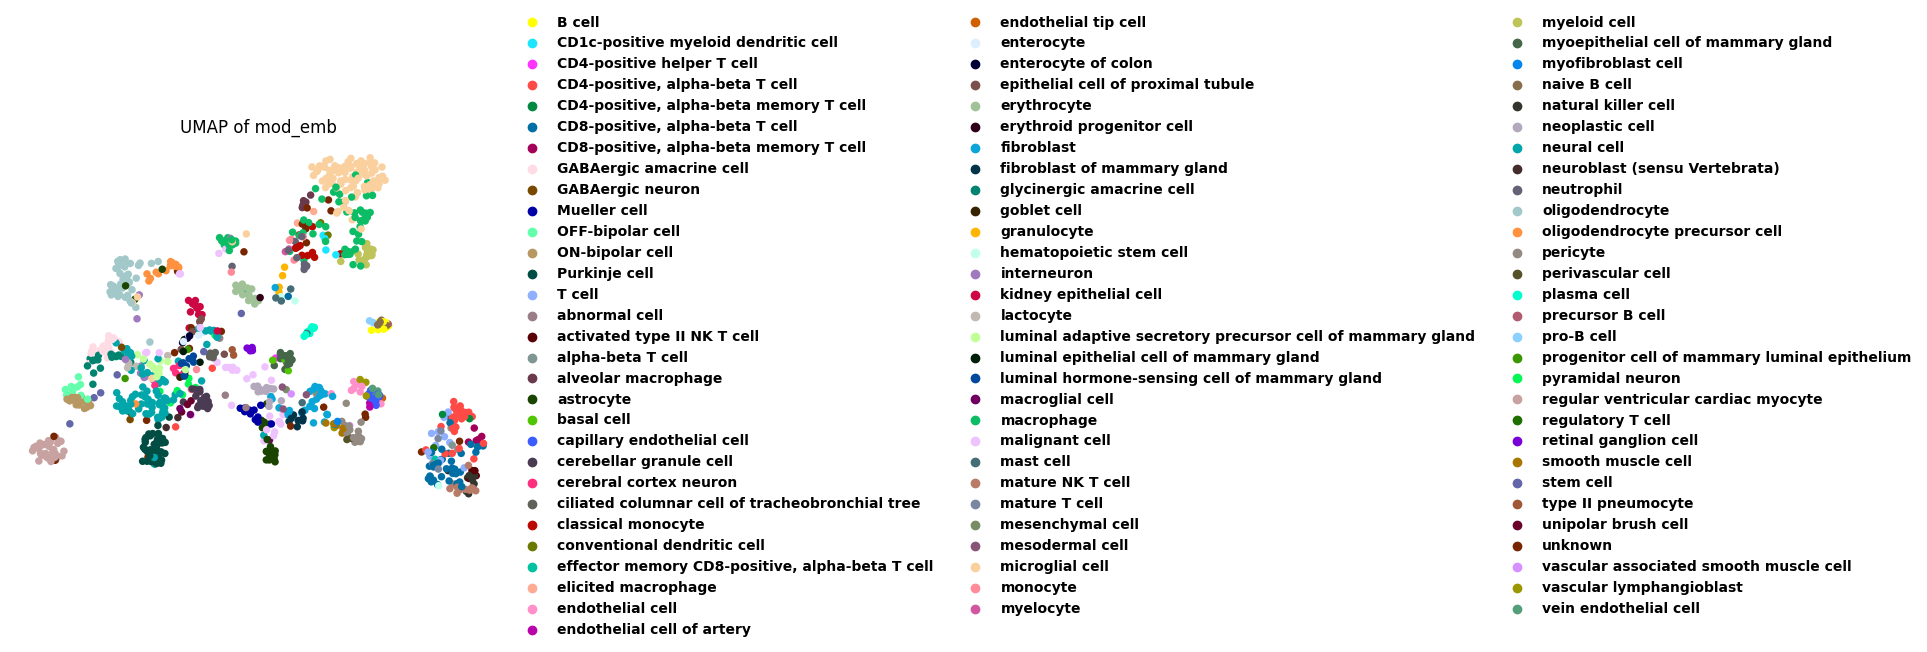

root - INFO - Displayed UMAP plot interactively.


In [18]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="mod_emb", save_plot=False)

mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.


<Figure size 800x800 with 0 Axes>

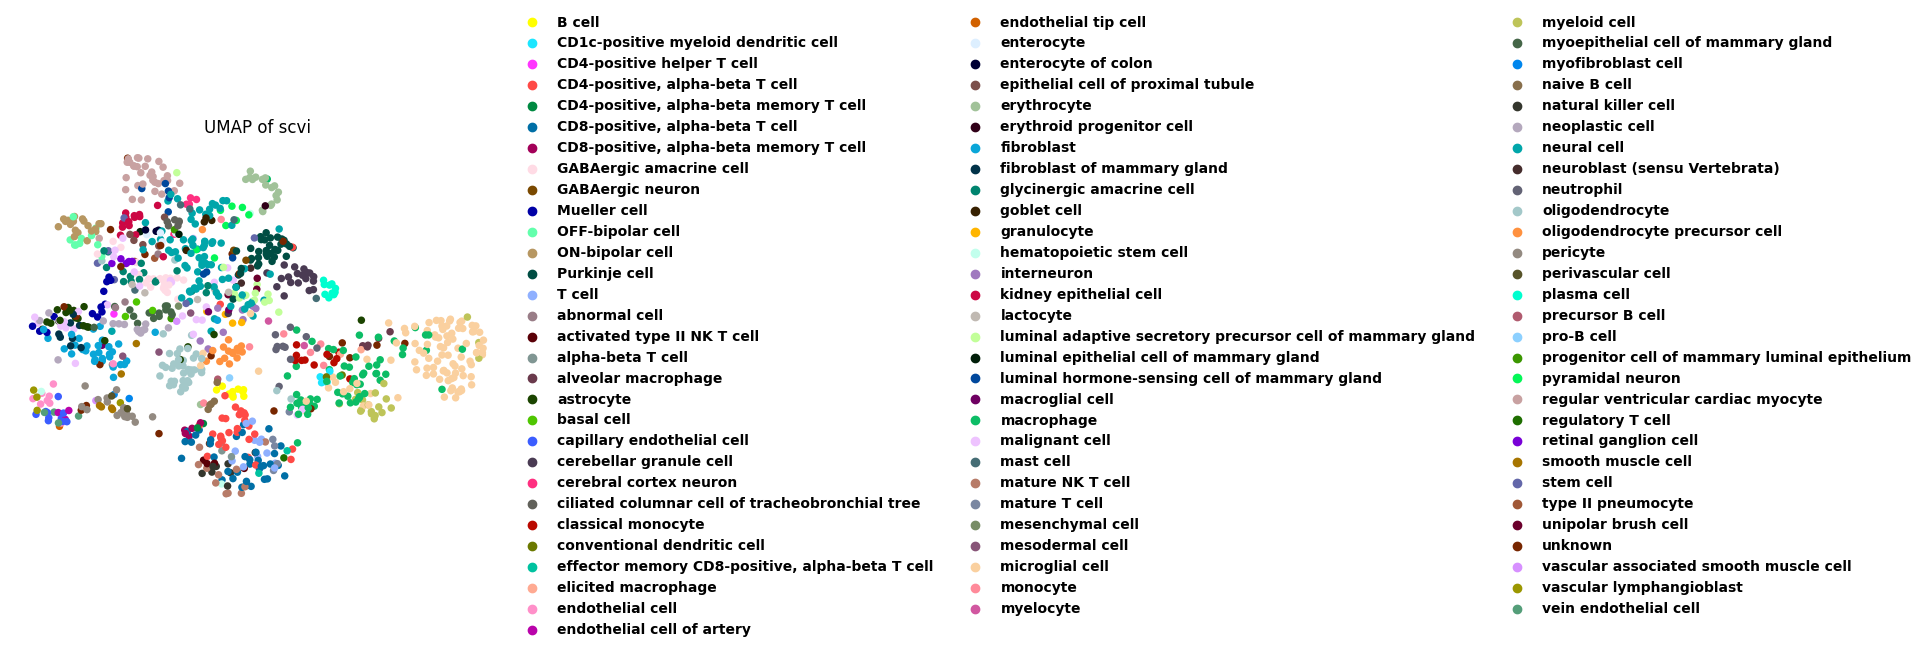

root - INFO - Displayed UMAP plot interactively.


In [19]:
plot_umap(inferred_adata, color_group="cell_type", embedding_key="scvi", save_plot=False)